In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [236]:
data = pd.read_csv('../../documents/data/nyc_restaurants.csv')

In [237]:
#rename columns
data_names = ['id', 'name', 'boro','bldg_num','street','zipcode','phone','cuisine','inspect_date','action','violation_code','violation_desc','critical_flag','score','grade','grade_date','record_date','inspect_type']
data.columns = data_names
data.columns

Index(['id', 'name', 'boro', 'bldg_num', 'street', 'zipcode', 'phone',
       'cuisine', 'inspect_date', 'action', 'violation_code', 'violation_desc',
       'critical_flag', 'score', 'grade', 'grade_date', 'record_date',
       'inspect_type'],
      dtype='object')

In [238]:
data.shape

(385670, 18)

In [311]:
data.groupby('violation_code')['critical_flag'].unique()

violation_code
02A    [Critical]      
02B    [Critical]      
02C    [Critical]      
02D    [Critical]      
02E    [Critical]      
02F    [Critical]      
02G    [Critical]      
02H    [Critical]      
02I    [Critical]      
03A    [Critical]      
03B    [Critical]      
03C    [Critical]      
03D    [Critical]      
03E    [Critical]      
03G    [Critical]      
04A    [Critical]      
04B    [Critical]      
04C    [Critical]      
04D    [Critical]      
04E    [Critical]      
04F    [Critical]      
04G    [Critical]      
04H    [Critical]      
04I    [Critical]      
04J    [Critical]      
04K    [Critical]      
04L    [Critical]      
04M    [Critical]      
04N    [Critical]      
04O    [Critical]      
          ...          
05H    [Critical]      
06A    [Critical]      
06B    [Critical]      
06C    [Critical]      
06D    [Critical]      
06E    [Critical]      
06F    [Critical]      
06G    [Critical]      
06I    [Critical]      
07A    [Critical]      
0

### Drop Rows with Nan Grades

In [239]:
#drop rows with NaN grade values
data.dropna(subset=['grade'],inplace=True)
data.shape

(194784, 18)

In [240]:
# find indexes of rows where grade equals P, Z, G or Not Yet Graded
grade_delete = data[(data['grade'] == 'P') | (data['grade'] == 'Z') | (data['grade'] == 'G') | (data['grade'] == 'Not Yet Graded')].index

In [241]:
# drop those indexes
data.drop(grade_delete, inplace=True)

In [242]:
# check if dropped
data.shape

(187136, 18)

In [302]:
data['violation_desc'].str.contains('mice').value_counts()

False    174545
True     11517 
Name: violation_desc, dtype: int64

In [299]:
data.groupby('violation_code')['violation_desc'].unique()

violation_code
02A    [Food not cooked to required minimum temperature.]                                                                                                                                                                                                                                                 
02B    [Hot food item not held at or above 140Âº F.]                                                                                                                                                                                                                                                      
02C    [Hot food item that has been cooked and refrigerated is being held for service without first being reheated to 1 65Âº F or above within 2 hours.]                                                                                                                                                  
02D    [Precooked potentially hazardous food from commercial food processing establishme

### Create Useful Functions

In [245]:
# function to get column values
def get_columns(rest_id, col):
    return data[data['id']==rest_id].iloc[0][col]

In [246]:
# testing
get_columns(30075445,'cuisine')

'Bakery'

In [247]:
#testing
get_columns(30075445,'boro')

'BRONX'

In [248]:
# function to get number of violation codes
def get_vcodes(rest_id, vcode):
    return data[(data['id']==rest_id) & (data['violation_code']==vcode)]['id'].count()

In [249]:
# testing
get_vcodes(30075445, '10F')

2

In [250]:
data['violation_code'].unique()

array(['02G', '06A', '08C', '09C', '04H', '10F', '04L', '04M', '10C',
       '04J', '04N', '10B', '04A', '10H', '05D', '02H', '10D', '06E',
       '02B', '06D', '06F', '08A', '10I', '06C', '04E', '04C', '06B',
       '10J', '09B', '06G', '04K', nan, '08B', '10E', '04F', '02I', '09A',
       '05F', '22F', '02C', '10A', '22G', '02A', '02F', '03B', '05H',
       '03A', '04O', '05C', '02D', '04D', '03G', '03C', '10G', '05E',
       '03E', '07A', '05B', '03D', '04B', '19A', '05A', '02E', '06I',
       '17A', '04G', '04I'], dtype=object)

In [251]:
data['violation_code'].nunique()

66

In [252]:
# function to get number of critical flags
def get_critical(rest_id, flag):
    return data[(data['id']==rest_id) & (data['critical_flag']==flag)]['id'].count()

In [253]:
data['critical_flag'].unique()

array(['Critical', 'Not Critical', 'Not Applicable'], dtype=object)

In [254]:
# testing
get_critical(30075445, 'Critical')

2

### Begin Constructing New DF with one Restaurant per Line

In [255]:
# get unique ids for each unique restaurant
ids = data.id.unique()

In [256]:
# add restaurants ids
df = pd.DataFrame(ids,columns=['id'])
df # there appears to be 25,249 unique restaurants

,id
0,40394258
1,50059515
2,50033875
3,50086524
4,41387635
5,40369641
6,50067183
7,41348986
8,50032946
9,50033317


In [257]:
#get cuisine values
values = [get_columns(i,'cuisine') for i in ids]

In [258]:
# add cuisine to df
df['cuisine'] = values
df

,id,cuisine
0,40394258,Italian
1,50059515,Chicken
2,50033875,Italian
3,50086524,Delicatessen
4,41387635,Mexican
5,40369641,Seafood
6,50067183,Pizza
7,41348986,Mexican
8,50032946,CafÃ©/Coffee/Tea
9,50033317,Chinese


In [259]:
# get critical flags counts 
cf = [get_critical(i, 'Critical') for i in ids]

In [260]:
# add to df
df['critical_flags'] = cf
df

,id,cuisine,critical_flags
0,40394258,Italian,9
1,50059515,Chicken,2
2,50033875,Italian,3
3,50086524,Delicatessen,1
4,41387635,Mexican,7
5,40369641,Seafood,5
6,50067183,Pizza,2
7,41348986,Mexican,13
8,50032946,CafÃ©/Coffee/Tea,4
9,50033317,Chinese,8


In [261]:
# get non-critical flags
ncf = [get_critical(i,'Not Critical') for i in ids]

In [262]:
# add to df
df['not_critical_flags'] = ncf
df

,id,cuisine,critical_flags,not_critical_flags
0,40394258,Italian,9,7
1,50059515,Chicken,2,0
2,50033875,Italian,3,3
3,50086524,Delicatessen,1,3
4,41387635,Mexican,7,4
5,40369641,Seafood,5,6
6,50067183,Pizza,2,4
7,41348986,Mexican,13,8
8,50032946,CafÃ©/Coffee/Tea,4,7
9,50033317,Chinese,8,2


In [263]:
# get not applicable flags
naf = [get_critical(i,'Not Applicable') for i in ids]

In [264]:
# add to df
df['not_applicable_flags'] = naf
df

,id,cuisine,critical_flags,not_critical_flags,not_applicable_flags
0,40394258,Italian,9,7,0
1,50059515,Chicken,2,0,0
2,50033875,Italian,3,3,0
3,50086524,Delicatessen,1,3,0
4,41387635,Mexican,7,4,0
5,40369641,Seafood,5,6,0
6,50067183,Pizza,2,4,0
7,41348986,Mexican,13,8,0
8,50032946,CafÃ©/Coffee/Tea,4,7,0
9,50033317,Chinese,8,2,0


In [265]:
# get boros
boros = [get_columns(i,'boro') for i in ids]

In [266]:
# add to df
df['boro'] = boros
df

,id,cuisine,critical_flags,not_critical_flags,not_applicable_flags,boro
0,40394258,Italian,9,7,0,BROOKLYN
1,50059515,Chicken,2,0,0,MANHATTAN
2,50033875,Italian,3,3,0,STATEN ISLAND
3,50086524,Delicatessen,1,3,0,BRONX
4,41387635,Mexican,7,4,0,QUEENS
5,40369641,Seafood,5,6,0,BRONX
6,50067183,Pizza,2,4,0,QUEENS
7,41348986,Mexican,13,8,0,BROOKLYN
8,50032946,CafÃ©/Coffee/Tea,4,7,0,MANHATTAN
9,50033317,Chinese,8,2,0,QUEENS


In [267]:
# get zipcodes
zips = [get_columns(i,'zipcode') for i in ids]

In [268]:
# add zipcodes to df
df['zipcode'] = zips
df

,id,cuisine,critical_flags,not_critical_flags,not_applicable_flags,boro,zipcode
0,40394258,Italian,9,7,0,BROOKLYN,11228.0
1,50059515,Chicken,2,0,0,MANHATTAN,10038.0
2,50033875,Italian,3,3,0,STATEN ISLAND,10309.0
3,50086524,Delicatessen,1,3,0,BRONX,10461.0
4,41387635,Mexican,7,4,0,QUEENS,11378.0
5,40369641,Seafood,5,6,0,BRONX,10464.0
6,50067183,Pizza,2,4,0,QUEENS,11106.0
7,41348986,Mexican,13,8,0,BROOKLYN,11220.0
8,50032946,CafÃ©/Coffee/Tea,4,7,0,MANHATTAN,10016.0
9,50033317,Chinese,8,2,0,QUEENS,11435.0


In [269]:
# get grade values for each restaurant
grades = [get_columns(i, 'grade') for i in ids]

In [270]:
# add grade values to df
df['grade'] = grades
df

,id,cuisine,critical_flags,not_critical_flags,not_applicable_flags,boro,zipcode,grade
0,40394258,Italian,9,7,0,BROOKLYN,11228.0,B
1,50059515,Chicken,2,0,0,MANHATTAN,10038.0,A
2,50033875,Italian,3,3,0,STATEN ISLAND,10309.0,A
3,50086524,Delicatessen,1,3,0,BRONX,10461.0,A
4,41387635,Mexican,7,4,0,QUEENS,11378.0,A
5,40369641,Seafood,5,6,0,BRONX,10464.0,A
6,50067183,Pizza,2,4,0,QUEENS,11106.0,A
7,41348986,Mexican,13,8,0,BROOKLYN,11220.0,B
8,50032946,CafÃ©/Coffee/Tea,4,7,0,MANHATTAN,10016.0,A
9,50033317,Chinese,8,2,0,QUEENS,11435.0,C


### Cleanup: Fix Missing Values, Rename Values, Map Numeric Values, Create Dummies, etc.

In [271]:
# check for missing boro values
df[df['boro']=='Missing']

,id,cuisine,critical_flags,not_critical_flags,not_applicable_flags,boro,zipcode,grade
841,50005059,American,15,8,0,Missing,11249.0,B
6545,50005134,American,5,4,0,Missing,11249.0,A
7938,50049804,Scandinavian,3,3,0,Missing,11249.0,A
13211,50011555,Pizza/Italian,2,4,0,Missing,10281.0,A
13290,50060598,Hawaiian,0,3,0,Missing,10168.0,A


In [272]:
#replace Missing boroughs with appropriate values

df.loc[(df['boro']=='Missing') & 
         (df['zipcode']==11249.0), 'boro'] = 'BROOKLYN'

df.loc[(df['boro']=='Missing') & 
         (df['zipcode']==10281.0), 'boro'] = 'MANHATTAN'

df.loc[(df['boro']=='Missing') & 
         (df['zipcode']==10168.0), 'boro'] = 'MANHATTAN'

#check
df[df['boro']=='Missing']

,id,cuisine,critical_flags,not_critical_flags,not_applicable_flags,boro,zipcode,grade


In [273]:
# map numeric values to A, B, C grade values
df['grade_num'] = df.grade.map({'A':1, 'B':2, 'C':3})
df

,id,cuisine,critical_flags,not_critical_flags,not_applicable_flags,boro,zipcode,grade,grade_num
0,40394258,Italian,9,7,0,BROOKLYN,11228.0,B,2
1,50059515,Chicken,2,0,0,MANHATTAN,10038.0,A,1
2,50033875,Italian,3,3,0,STATEN ISLAND,10309.0,A,1
3,50086524,Delicatessen,1,3,0,BRONX,10461.0,A,1
4,41387635,Mexican,7,4,0,QUEENS,11378.0,A,1
5,40369641,Seafood,5,6,0,BRONX,10464.0,A,1
6,50067183,Pizza,2,4,0,QUEENS,11106.0,A,1
7,41348986,Mexican,13,8,0,BROOKLYN,11220.0,B,2
8,50032946,CafÃ©/Coffee/Tea,4,7,0,MANHATTAN,10016.0,A,1
9,50033317,Chinese,8,2,0,QUEENS,11435.0,C,3


In [274]:
# Top cuisines by number of restaurants
df.groupby('cuisine')['id'].nunique().sort_values(ascending=False).head(10)

cuisine
American                                                            5824
Chinese                                                             2368
CafÃ©/Coffee/Tea                                                    1697
Pizza                                                               1174
Italian                                                             982 
Mexican                                                             907 
Japanese                                                            856 
Latin (Cuban, Dominican, Puerto Rican, South & Central American)    806 
Bakery                                                              722 
Caribbean                                                           677 
Name: id, dtype: int64

In [275]:
# Rename super long cuisine names
df.cuisine.replace(['CafÃ©/Coffee/Tea',"Latin (Cuban, Dominican, Puerto Rican, South & Central American)"], 
                     ['Cafe','Latin'], inplace=True)

In [276]:
# Create new column establishing top ten cuisines and other
top_ten = ['American','Chinese', 'Cafe','Pizza','Italian','Mexican','Japanese','Latin','Bakery', 'Caribbean']

df['cuisine_edit'] = np.where(df['cuisine'].isin(top_ten),df['cuisine'],'Other')

In [277]:
# dummify cuisine
cuisine_dummies = pd.get_dummies(df.cuisine_edit, prefix='cuisine', drop_first=True)
cuisine_dummies

,cuisine_Bakery,cuisine_Cafe,cuisine_Caribbean,cuisine_Chinese,cuisine_Italian,cuisine_Japanese,cuisine_Latin,cuisine_Mexican,cuisine_Other,cuisine_Pizza
0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,1,0,0
8,0,1,0,0,0,0,0,0,0,0
9,0,0,0,1,0,0,0,0,0,0


In [278]:
# dummify boros
boro_dummies = pd.get_dummies(df.boro, prefix='boro', drop_first=True)
boro_dummies

,boro_BROOKLYN,boro_MANHATTAN,boro_QUEENS,boro_STATEN ISLAND
0,1,0,0,0
1,0,1,0,0
2,0,0,0,1
3,0,0,0,0
4,0,0,1,0
5,0,0,0,0
6,0,0,1,0
7,1,0,0,0
8,0,1,0,0
9,0,0,1,0


In [279]:
df.head()

,id,cuisine,critical_flags,not_critical_flags,not_applicable_flags,boro,zipcode,grade,grade_num,cuisine_edit
0,40394258,Italian,9,7,0,BROOKLYN,11228.0,B,2,Italian
1,50059515,Chicken,2,0,0,MANHATTAN,10038.0,A,1,Other
2,50033875,Italian,3,3,0,STATEN ISLAND,10309.0,A,1,Italian
3,50086524,Delicatessen,1,3,0,BRONX,10461.0,A,1,Other
4,41387635,Mexican,7,4,0,QUEENS,11378.0,A,1,Mexican


In [280]:
# add dummy dfs to main df
df_dummies = pd.concat([df, boro_dummies, cuisine_dummies], axis=1)
df_dummies.head()

,id,cuisine,critical_flags,not_critical_flags,not_applicable_flags,boro,zipcode,grade,grade_num,cuisine_edit,boro_BROOKLYN,boro_MANHATTAN,boro_QUEENS,boro_STATEN ISLAND,cuisine_Bakery,cuisine_Cafe,cuisine_Caribbean,cuisine_Chinese,cuisine_Italian,cuisine_Japanese,cuisine_Latin,cuisine_Mexican,cuisine_Other,cuisine_Pizza
0,40394258,Italian,9,7,0,BROOKLYN,11228.0,B,2,Italian,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,50059515,Chicken,2,0,0,MANHATTAN,10038.0,A,1,Other,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,50033875,Italian,3,3,0,STATEN ISLAND,10309.0,A,1,Italian,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,50086524,Delicatessen,1,3,0,BRONX,10461.0,A,1,Other,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,41387635,Mexican,7,4,0,QUEENS,11378.0,A,1,Mexican,0,0,1,0,0,0,0,0,0,0,0,1,0,0


### Modeling Process

In [281]:
# create feature matrix
data_cols = ['critical_flags','not_critical_flags','not_applicable_flags','boro_BROOKLYN','boro_MANHATTAN','boro_QUEENS', 'boro_STATEN ISLAND', 'cuisine_Bakery', 'cuisine_Cafe', 'cuisine_Caribbean', 'cuisine_Chinese', 'cuisine_Italian', 'cuisine_Japanese', 'cuisine_Latin', 'cuisine_Mexican', 'cuisine_Other', 'cuisine_Pizza']

eat = df_dummies

X = eat[data_cols]
y = eat['grade_num']

In [282]:
#train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

In [283]:
#standardize X_train and X_test

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train) #overwrite
X_test = scaler.transform(X_test)

C:\Users\597154\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\597154\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  
C:\Users\597154\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  import sys


### KNN Attempt

In [284]:
# KFolds Cross validation
kf = KFold(n_splits=5, shuffle=True)

# loop k through a range
k_range = range(1,21)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    cv_score = np.mean(cross_val_score(knn, X_train, y_train, cv = kf))
    scores.append([k, cv_score])

In [285]:
# check scores
scores

[[1, 0.8133184888334432],
 [2, 0.8714615163473998],
 [3, 0.8630125179537955],
 [4, 0.8746306139856548],
 [5, 0.874788730077247],
 [6, 0.878432217816244],
 [7, 0.8777461465040883],
 [8, 0.878696948293905],
 [9, 0.8784853646764107],
 [10, 0.8800693139900325],
 [11, 0.8793830335480493],
 [12, 0.8785910031232843],
 [13, 0.878802154539135],
 [14, 0.8793301655276526],
 [15, 0.8799111003045208],
 [16, 0.8784854901543071],
 [17, 0.8792244852548136],
 [18, 0.8804391391770154],
 [19, 0.8802281829490038],
 [20, 0.8795937806462335]]

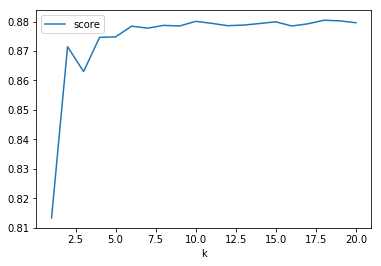

In [286]:
# plot to find best k
model_data = pd.DataFrame(scores, columns=['k','score'])
model_data.plot.line(x ='k',y ='score')

In [295]:
#fit model with best k
knn = KNeighborsClassifier(n_neighbors = 18)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=18, p=2,
           weights='uniform')

In [296]:
#find accuracy score and testing error
y_pred = knn.predict(X_test)
testing_accuracy = metrics.accuracy_score(y_test,y_pred)
testing_error = 1 - testing_accuracy

testing_accuracy

0.8834151750356407

In [289]:
# baseline
y_train.value_counts()/len(y_train)

1    0.879172
2    0.093156
3    0.027672
Name: grade_num, dtype: float64

#### Conclusion: 

Testing accuracy score is slightly better than the baseline, signaling a fairly accurate model. 

### LogReg Attempt

In [290]:
logreg = LogisticRegression(C=1e9, solver='lbfgs', multi_class='auto') 

print(np.mean(cross_val_score(logreg, X_train, y_train, cv=kf))) 

0.8821295773988098


In [291]:
#fit the data
logreg.fit(X_train,y_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='auto', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [292]:
#train data accuracy score
logreg.score(X_train,y_train)

0.882446134347275

In [293]:
#test data accuracy score
logreg.score(X_test,y_test)

0.8869000475209884

In [294]:
# compare with baseline
y_train.value_counts() / len(y_train)

1    0.879172
2    0.093156
3    0.027672
Name: grade_num, dtype: float64

#### Conclusion
Model seems pretty good because the two accuracy scores are very comparable. The test data accuracy score is a little higher. In addition, they are both better than the baseline, signifying a relatively good model. 